<a href="https://colab.research.google.com/github/Rithvikns/Machine_Learning/blob/main/Supervised_Learning/Both_classification_Regression/XGBoost/implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fitting 3 folds for each of 20 candidates, totalling 60 fits
🔍 Best Parameters:
 {'xgb__subsample': 1.0, 'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.2, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.7}

📋 Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



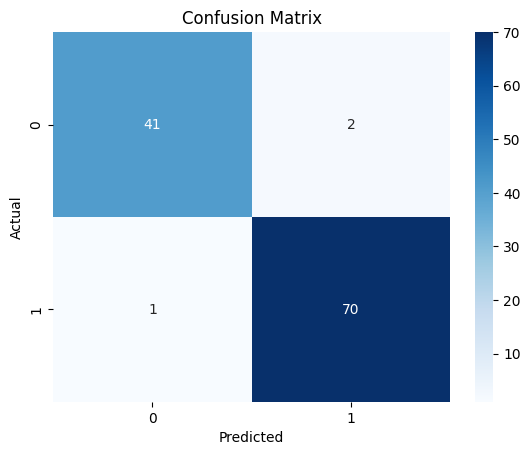

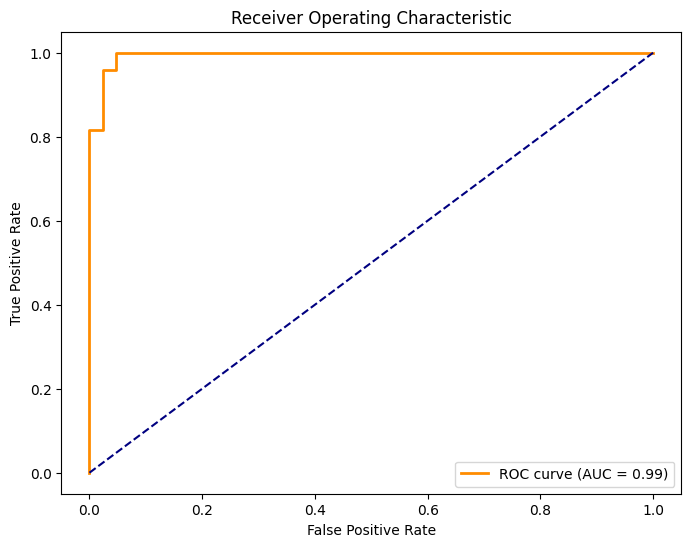

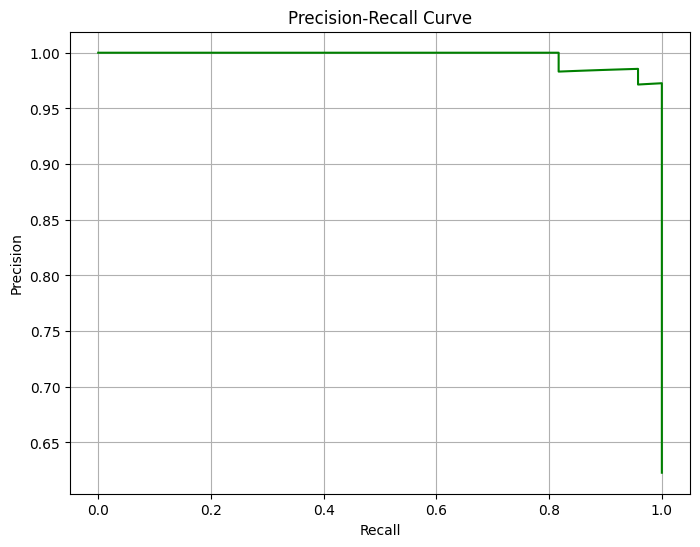

<Figure size 1200x800 with 0 Axes>

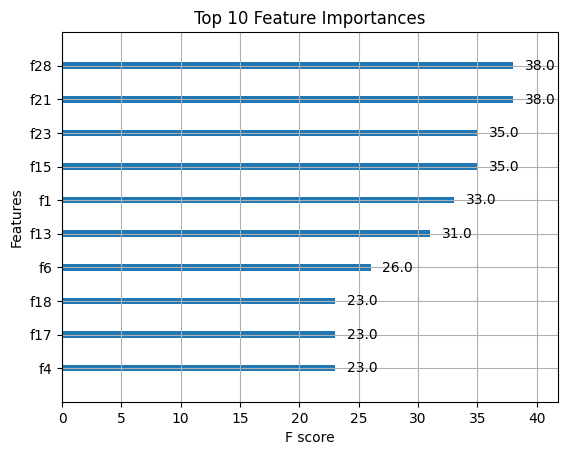

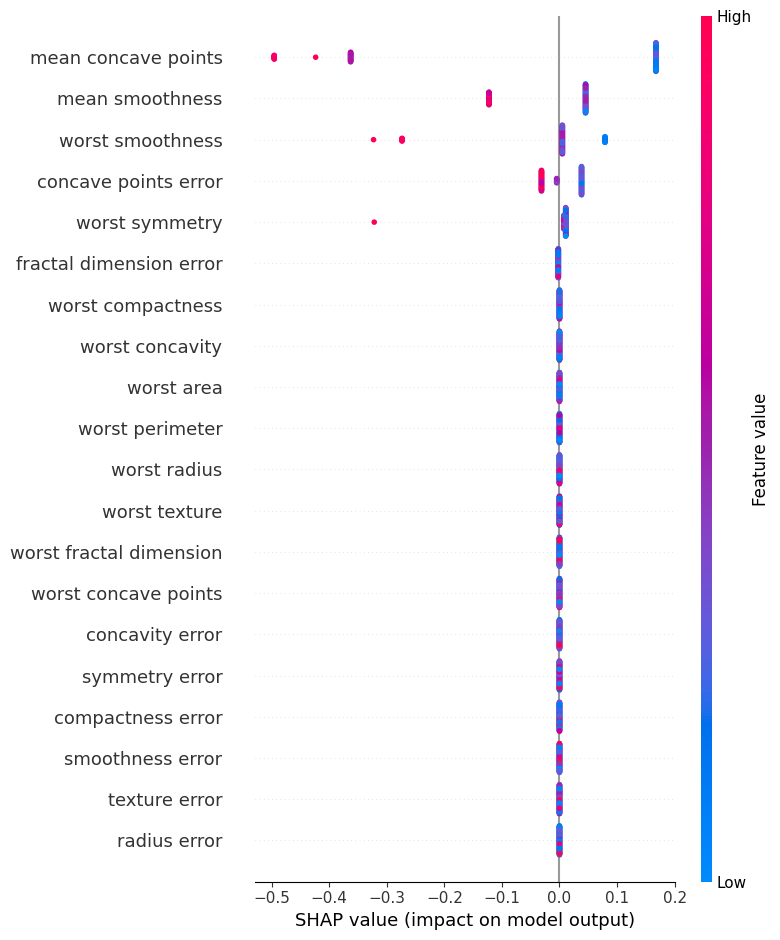

In [1]:
# ================================
# Advanced XGBoost Pipeline (Colab)
# ================================

# Install dependencies
!pip install xgboost shap seaborn scikit-learn matplotlib --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, plot_importance

# Step 1: Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build pipeline with scaler and XGBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Step 4: Hyperparameter tuning (RandomizedSearchCV for speed)
params = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__max_depth': [3, 4, 5, 6],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0],
    'xgb__gamma': [0, 1, 5]
}

search = RandomizedSearchCV(pipeline, params, n_iter=20, scoring='roc_auc', n_jobs=-1, cv=3, verbose=1)
search.fit(X_train, y_train)

print("🔍 Best Parameters:\n", search.best_params_)

# Step 5: Evaluate best model
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# Step 6: Feature Importance
xgb_model = best_model.named_steps['xgb']

plt.figure(figsize=(12, 8))
plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

# Step 7: SHAP values for interpretability
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)
